,A0,A1,A2
Hetna-XDH,-9.000000e-08,1.900000e-05,-0.04750
Hetna-DH,-3.000000e-08,-5.007143e-20,-0.03000
Q cells-XDH,-1.500000e-08,1.850000e-05,-0.05625
Q cells-DH,1.073247e-23,-1.500000e-05,-0.03500
Jinergy-XDH,-1.500000e-08,1.450000e-05,-0.01875
Jinergy-DH,2.500000e-09,-1.250000e-05,-0.01000


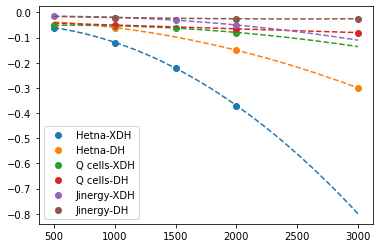

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

ORDER = 2

file = r'C:\Users\franc\PVcharacterization_files\essai_fit.xlsx'
df = pd.read_excel(file)
df.rename(columns={"Unnamed: 0":"titre0",
                   "Unnamed: 1":"titre1"},
         inplace=True)

# Takes care of the nan in titr0 column
titre1_corrige = []
list_titre = df['titre0'].tolist()
for i, titre in enumerate(list_titre): 
    if i%2 == 1:
        titre1_corrige.append(list_titre[i-1])
    else:
        titre1_corrige.append(list_titre[i])      
df['titre0'] = titre1_corrige

x = [float(y[0:-1]) for y in df.columns if 'h' in y]
x_fit = np.linspace(min(x),max(x),200)

dic_coef = {}
for index_row in df.index:
    label = df.iloc[index_row,0]+ '-' + df.iloc[index_row,1]
    y = df.iloc[index_row,[2,3,4,5,6,7]].tolist()
    
    x_for_fit = []
    y_for_fit = []
    for x1, y1, test in zip(x,y,np.isnan(y)): # skip nan for the fit
        if not test:
            x_for_fit.append(x1)
            y_for_fit.append(y1)
    z = np.polyfit(x_for_fit, y_for_fit, ORDER)
    dic_coef[label] = z
    p = np.poly1d(z)
    plt.scatter(x,y,label=label)
    plt.plot(x_fit,p(x_fit),'--')
plt.legend()

df_coeff = pd.DataFrame(dic_coef).T
df_coeff.rename(columns={i:'A'+str(i) for i in range(len(df_coeff.columns))},
         inplace=True)
df_coeff.head(20)